[*********************100%%**********************]  1 of 1 completed


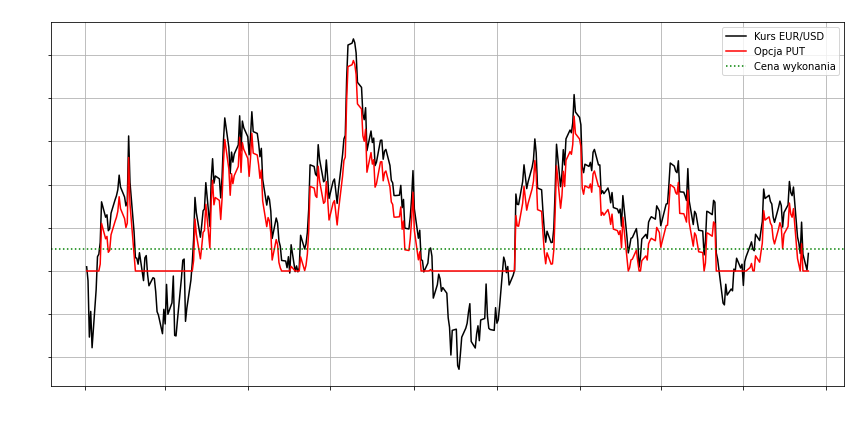

"plt.figure(figsize=[13,7])\nplt.title('Kurs walutowy USD/EUR z 21.01.2020 do 20.04.2024', color = 'yellow')\nplt.plot(data['Data'], data['Ostatnio'])\nplt.xlabel('Data', color = 'yellow')\nplt.ylabel('Cena', color = 'yellow')\nplt.xticks(color = 'yellow')\nplt.yticks(color = 'yellow')\nplt.grid(True)\nplt.tight_layout()\nplt.savefig('Kurs_walutowy_USD_EUR.png')\n"

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

eur_usd = yf.download('EURUSD=X', start='2023-01-01', end='2024-06-18', interval='1d')

# Prepare the DataFrame
data = pd.DataFrame({'Date': eur_usd.index, 'EUR/USD': eur_usd['Close']})
data.set_index('Date', inplace=True)


# Option parameters
strike_price = 1.075
premium = 0.005
expiration_date = pd.to_datetime("2023-06-30")

# Calculate the value of the PUT option at expiration
data['PUT'] = np.maximum(strike_price, data['EUR/USD']) - premium
#data['PUT Value'] = np.maximum(strike_price - data['EUR/USD'], 0) - premium
# Filter the data up to the expiration date

plt.figure(figsize=(12, 6))
plt.plot(data.index.to_numpy(), data['EUR/USD'].to_numpy(), label='Kurs EUR/USD', color='black')
plt.plot(data.index.to_numpy(), data['PUT'].to_numpy(), label='Opcja PUT', color='red')

'''
filtered_data = data[data.index <= expiration_date]

# Plotting the EUR/USD exchange rate and PUT option value
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index.to_numpy(), filtered_data['EUR/USD'].to_numpy(), label='EUR/USD Exchange Rate', color='blue')
plt.plot(filtered_data.index.to_numpy(), filtered_data['PUT Value'].to_numpy(), label='PUT Option Value', color='red', linestyle='--')
'''
plt.axhline(y=strike_price, color='green', linestyle=':', label='Cena wykonania')
#plt.axhline(y=premium, color='orange', linestyle=':', label='Premium')

plt.title('Kurs wymiany EUR/USD i wartość opcji PUT', color = 'white')
plt.xlabel('Data', color = 'white')
plt.ylabel('Wartość', color = 'white')
plt.legend()
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(True)
plt.tight_layout()
plt.savefig('Kurs_opcja.png')
plt.show()

'''plt.figure(figsize=[13,7])
plt.title('Kurs walutowy USD/EUR z 21.01.2020 do 20.04.2024', color = 'yellow')
plt.plot(data['Data'], data['Ostatnio'])
plt.xlabel('Data', color = 'yellow')
plt.ylabel('Cena', color = 'yellow')
plt.xticks(color = 'yellow')
plt.yticks(color = 'yellow')
plt.grid(True)
plt.tight_layout()
plt.savefig('Kurs_walutowy_USD_EUR.png')
'''


In [67]:
data["d_after"] = data["EUR/USD"].shift(-1)
data = data.fillna(data["EUR/USD"].iloc[-1])
data['log_return'] = np.log(data['d_after']/data['EUR/USD'])
data = data.drop(data.index[-1])

data["d_after"] = data["PUT"].shift(-1)
data = data.fillna(data["PUT"].iloc[-1])
data['log_return_PUT'] = np.log(data['d_after']/data['PUT'])
data = data.drop(data.index[-1])


In [68]:
print("Historical usual method VaR95%:", np.quantile(data['log_return'], 0.05))
print("Historical usual method VaR99%:", np.quantile(data['log_return'], 0.01))
print("Historical usual method VaR95%:", np.quantile(data['log_return_PUT'], 0.05))
print("Historical usual method VaR99%:", np.quantile(data['log_return_PUT'], 0.01))
print("srednia kurs", np.mean(data['log_return']))
print("odchyl kurs", np.std(data['log_return']))
print("srednia put", np.mean(data['log_return_PUT']))
print("odchyl put", np.std(data['log_return_PUT']))

Historical usual method VaR95%: -0.007231918723045896
Historical usual method VaR99%: -0.01070993557667564
Historical usual method VaR95%: -0.006128454933804255
Historical usual method VaR99%: -0.009481999110748773
srednia kurs -1.8595219931737063e-06
odchyl kurs 0.004368961163474879
srednia put -4.651797952685175e-18
odchyl put 0.003473402905123465


In [69]:
volatility = data['log_return_PUT'].std() * np.sqrt(252)  # 252 dni handlowych w roku

# Bieżący kurs EUR/USD
current_price = data['PUT'].iloc[-1]

# Przykładowa stopa procentowa wolna od ryzyka
risk_free_rate_usd = 0.05  # np. 5% dla obligacji skarbowych USA
risk_free_rate_eur = 0.02  # np. 2% dla obligacji skarbowych strefy euro

print(f"Bieżący kurs EUR/USD: {current_price}")
print(f"Roczna zmienność: {volatility}")
print(f"Stopa procentowa wolna od ryzyka (USD): {risk_free_rate_usd}")
print(f"Stopa procentowa wolna od ryzyka (EUR): {risk_free_rate_eur}")

current_price

Bieżący kurs EUR/USD: 1.07
Roczna zmienność: 0.055211255986639216
Stopa procentowa wolna od ryzyka (USD): 0.05
Stopa procentowa wolna od ryzyka (EUR): 0.02


1.07

In [70]:
import numpy as np
import scipy.stats as stats

# Przykładowe dane
S = current_price
K = strike_price  # Cena wykonania
T = 180    # Czas do wygaśnięcia (1 rok)
r = 0.02
sigma = volatility

# Obliczenie d1 i d2
d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)


delta_put = stats.norm.cdf(d1) - 1

# Gamma
gamma = stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))

# Vega
vega = S * stats.norm.pdf(d1) * np.sqrt(T) / 100  # Często wyrażana w punktach procentowych

theta_put = (-S * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             + r * K * np.exp(-r * T) * stats.norm.cdf(-d2)) / 365  # Często wyrażana na dzień

# Rho

rho_put = -K * T * np.exp(-r * T) * stats.norm.cdf(-d2) / 100  # Często wyrażana w punktach procentowych

# Wyniki
print("Delta Put:", delta_put)
print("Gamma:", gamma)
print("Vega:", vega)
print("Theta Put:", theta_put)
print("Rho Put:", rho_put)



Delta Put: -8.750165347848338e-08
Gamma: 5.965501916026764e-07
Vega: 6.787575554913205e-08
Theta Put: 3.060871948118278e-12
Rho Put: -1.9423728636842738e-07


In [71]:
import numpy as np
import scipy.stats as stats
strike_price = 1.07
# Przykładowe dane
S = data['PUT']
K = strike_price  # Cena wykonania
T = 180    # Czas do wygaśnięcia (1 rok)
r = 0.02
sigma = volatility

# Obliczenie d1 i d2
data['d1'] = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
data['d2'] = data['d1'] - sigma * np.sqrt(T)


delta = stats.norm.cdf(data['d1']) - 1
delta_put = np.mean(delta)

# Gamma
gamm = stats.norm.pdf(data['d1']) / (S * sigma * np.sqrt(T))
gamma = np.mean(gamm)
# Vega
veg = S * stats.norm.pdf(data['d1']) * np.sqrt(T) / 100  # Często wyrażana w punktach procentowych
vega = np.mean(veg)

theta = (-S * stats.norm.pdf(data['d1']) * sigma / (2 * np.sqrt(T))
             + r * K * np.exp(-r * T) * stats.norm.cdf(-data['d2'])) / 365  # Często wyrażana na dzień
theta_put = np.mean(theta)
# Rho

rho = -K * T * np.exp(-r * T) * stats.norm.cdf(-data['d2']) / 100  # Często wyrażana w punktach procentowych
rho_put = np.mean(rho)
# Wyniki
print("Delta Put:", delta_put)
print("Gamma:", gamma)
print("Vega:", vega)
print("Theta Put:", theta_put)
print("Rho Put:", rho_put)

Delta Put: -7.922416757417438e-08
Gamma: 5.372244993892677e-07
Vega: 6.218894855795627e-08
Theta Put: 2.784484636687012e-12
Rho Put: -1.7730856927449986e-07
